In [18]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [19]:
!unzip "/content/drive/MyDrive/Lung_cancer_dataset.zip"

Archive:  /content/drive/MyDrive/Lung_cancer_dataset.zip
replace Lung_cancer_dataset/Test/0/Bengin case (102).jpg? [y]es, [n]o, [A]ll, [N]one, [r]ename: A
  inflating: Lung_cancer_dataset/Test/0/Bengin case (102).jpg  
  inflating: Lung_cancer_dataset/Test/0/Bengin case (113).jpg  
  inflating: Lung_cancer_dataset/Test/0/Bengin case (114).jpg  
  inflating: Lung_cancer_dataset/Test/0/Bengin case (115).jpg  
  inflating: Lung_cancer_dataset/Test/0/Bengin case (116).jpg  
  inflating: Lung_cancer_dataset/Test/0/Bengin case (117).jpg  
  inflating: Lung_cancer_dataset/Test/0/Bengin case (118).jpg  
  inflating: Lung_cancer_dataset/Test/0/Bengin case (119).jpg  
  inflating: Lung_cancer_dataset/Test/0/Bengin case (120).jpg  
  inflating: Lung_cancer_dataset/Test/0/Bengin case (16).jpg  
  inflating: Lung_cancer_dataset/Test/0/Bengin case (25).jpg  
  inflating: Lung_cancer_dataset/Test/0/Bengin case (40).jpg  
  inflating: Lung_cancer_dataset/Test/0/Bengin case (45).jpg  
  inflating: Lung

In [40]:
import numpy as np 
import pandas as pd 
import matplotlib.pyplot as plt
import cv2
from PIL import Image
import os
from sklearn.model_selection import train_test_split
from keras.utils import to_categorical
from keras.models import Sequential, load_model
from keras.layers import Conv2D, MaxPooling2D, Dense, Flatten, Dropout, BatchNormalization
from keras.optimizers import SGD, Adam
from keras.regularizers import l2

In [41]:
data = []
labels = []
classes = 3
img_rows, img_cols, channels= 64,64,3
cur_path = os.getcwd()

In [42]:
#Retrieving the images and their labels 
img_path = r"/content/Lung_cancer_dataset/Train"
for i in range(classes):
    path = os.path.join(img_path,str(i))
    images = os.listdir(path)
    for a in images:
        try:
            image = Image.open(path + '/'+ a)
            image = image.resize((64,64))
            image = np.array(image)
            data.append(image)
            labels.append(i)
        except:
            print("Error loading image")

In [43]:
#Converting lists into numpy arrays
data = np.array(data)
labels = np.array(labels)

print(data.shape, labels.shape)

(1037, 64, 64, 3) (1037,)


In [44]:
#Splitting training and testing dataset
x_train, x_test, y_train, y_test = train_test_split(data, labels, test_size=0.2, random_state=42)

print(x_train.shape, x_test.shape, y_train.shape, y_test.shape)

(829, 64, 64, 3) (208, 64, 64, 3) (829,) (208,)


In [45]:
#Converting the labels into one hot encoding
y_train = to_categorical(y_train, 3)
y_test = to_categorical(y_test, 3)


In [46]:
# build and compile the model  (roughly following the VGG paper)
#TODO:
#reg=l2(1e-4)   # L2 or "ridge" regularisation
reg=None
num_filters=32
ac='relu'
opt=Adam(lr=0.001,decay=0, beta_1=0.9, beta_2=0.999, epsilon=1e-08)
drop_dense=0.5
drop_conv=0

model = Sequential()

model.add(Conv2D(num_filters, (3, 3), activation=ac, kernel_regularizer=reg, input_shape=(img_rows, img_cols, channels),padding='same'))
model.add(BatchNormalization(axis=-1))
model.add(Conv2D(num_filters, (3, 3), activation=ac,kernel_regularizer=reg,padding='same'))
model.add(BatchNormalization(axis=-1))
model.add(MaxPooling2D(pool_size=(2, 2)))   # reduces to 16x16x3xnum_filters
model.add(Dropout(drop_conv))

model.add(Conv2D(2*num_filters, (3, 3), activation=ac,kernel_regularizer=reg,padding='same'))
model.add(BatchNormalization(axis=-1))
model.add(Conv2D(2*num_filters, (3, 3), activation=ac,kernel_regularizer=reg,padding='same'))
model.add(BatchNormalization(axis=-1))
model.add(MaxPooling2D(pool_size=(2, 2)))   # reduces to 8x8x3x(2*num_filters)
model.add(Dropout(drop_conv))

model.add(Conv2D(4*num_filters, (3, 3), activation=ac,kernel_regularizer=reg,padding='same'))
model.add(BatchNormalization(axis=-1))
model.add(Conv2D(4*num_filters, (3, 3), activation=ac,kernel_regularizer=reg,padding='same'))
model.add(BatchNormalization(axis=-1))
model.add(MaxPooling2D(pool_size=(2, 2)))   # reduces to 4x4x3x(4*num_filters)
model.add(Dropout(drop_conv))

model.add(Flatten())
model.add(Dense(512, activation=ac,kernel_regularizer=reg))
model.add(BatchNormalization())
model.add(Dropout(drop_dense))
model.add(Dense(classes, activation='softmax'))

model.compile(loss='categorical_crossentropy', metrics=['accuracy'],optimizer=opt)


In [47]:
model.summary()

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_18 (Conv2D)          (None, 64, 64, 32)        896       
                                                                 
 batch_normalization_21 (Bat  (None, 64, 64, 32)       128       
 chNormalization)                                                
                                                                 
 conv2d_19 (Conv2D)          (None, 64, 64, 32)        9248      
                                                                 
 batch_normalization_22 (Bat  (None, 64, 64, 32)       128       
 chNormalization)                                                
                                                                 
 max_pooling2d_9 (MaxPooling  (None, 32, 32, 32)       0         
 2D)                                                             
                                                      

In [48]:
# training without augmentation
history=model.fit(x_train, y_train, batch_size=128, epochs=100, validation_data=(x_test, y_test))

Epoch 1/100
7/7 [==============================] - 2s 102ms/step - loss: 1.1541 - accuracy: 0.6683 - val_loss: 11.8493 - val_accuracy: 0.5288
Epoch 2/100
7/7 [==============================] - 0s 55ms/step - loss: 0.2133 - accuracy: 0.9095 - val_loss: 8.8700 - val_accuracy: 0.5288
Epoch 3/100
7/7 [==============================] - 0s 55ms/step - loss: 0.0914 - accuracy: 0.9747 - val_loss: 7.1765 - val_accuracy: 0.5288
Epoch 4/100
7/7 [==============================] - 0s 55ms/step - loss: 0.0361 - accuracy: 0.9928 - val_loss: 5.2222 - val_accuracy: 0.5288
Epoch 5/100
7/7 [==============================] - 0s 54ms/step - loss: 0.0132 - accuracy: 0.9976 - val_loss: 3.8672 - val_accuracy: 0.5288
Epoch 6/100
7/7 [==============================] - 0s 55ms/step - loss: 0.0144 - accuracy: 0.9976 - val_loss: 2.7433 - val_accuracy: 0.5288
Epoch 7/100
7/7 [==============================] - 0s 62ms/step - loss: 0.0078 - accuracy: 0.9976 - val_loss: 2.0369 - val_accuracy: 0.5288
Epoch 8/100
7/7 [=

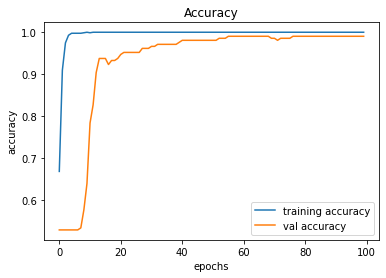

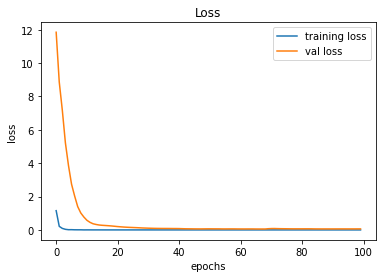

In [49]:
#plotting graphs for accuracy 
plt.figure(0)
plt.plot(history.history['accuracy'], label='training accuracy')
plt.plot(history.history['val_accuracy'], label='val accuracy')
plt.title('Accuracy')
plt.xlabel('epochs')
plt.ylabel('accuracy')
plt.legend()
plt.show()

plt.figure(1)
plt.plot(history.history['loss'], label='training loss')
plt.plot(history.history['val_loss'], label='val loss')
plt.title('Loss')
plt.xlabel('epochs')
plt.ylabel('loss')
plt.legend()
plt.show()

In [50]:
# #testing accuracy on test dataset
# from sklearn.metrics import accuracy_score

# y = pd.read_csv(r'/content/Test.csv')

# y_test = y["ClassId"].values
# imgs = y["Path"].values

# data=[]
# s = "/content"
# for img in imgs:
#     p = os.path.join(s, img)
#     image = Image.open(img)
#     image = image.resize((32,32))
#     data.append(np.array(image))

# x_test=np.array(data)
# y_test = np.array(y_test)
# y_test = to_categorical(y_test, 43)
#Retrieving the images and their labels 
x_test = []
y_test = []
img_path = r"/content/Lung_cancer_dataset/Test"
for i in range(classes):
    path = os.path.join(img_path,str(i))
    images = os.listdir(path)
    for a in images:
        try:
            image = Image.open(path + '/'+ a)
            image = image.resize((64,64))
            image = np.array(image)
            x_test.append(image)
            y_test.append(i)
        except:
            print("Error loading image")

#Converting lists into numpy arrays
x_test = np.array(x_test)
y_test = np.array(y_test)
temp = y_test
#one-hot encoding
y_test = to_categorical(y_test, 3)

In [51]:
print(y_test.shape, x_test.shape)

(60, 3) (60, 64, 64, 3)


In [52]:
print("Evaluate on test data")
results = model.evaluate(x_test, y_test, batch_size=8)
print("test loss, test acc:", results)

Evaluate on test data
8/8 [==============================] - 0s 4ms/step - loss: 0.6309 - accuracy: 0.8833
test loss, test acc: [0.6308765411376953, 0.8833333253860474]


In [53]:
from sklearn.metrics import confusion_matrix

y_pred = model.predict(x_test)
y_pred = np.argmax(y_pred, axis=1)
y_test = temp

index = [0 for i in range(3)]
for i in range(3):
    index[i] = i + 1;
columns = index

conf_mat = confusion_matrix(y_test, y_pred)
cm_df = pd.DataFrame(conf_mat,
                     index , 
                     columns )


2/2 [==============================] - 0s 7ms/step


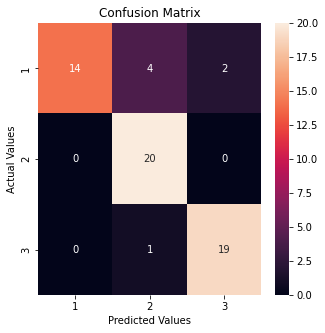

In [54]:
#Plotting the confusion matrix
import seaborn as sns
plt.figure(figsize=(5,5))
sns.heatmap(cm_df, annot=True)
plt.title('Confusion Matrix')
plt.ylabel('Actual Values')
plt.xlabel('Predicted Values')
plt.show()